In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline 

import os
import sys
sys.path.append("../data/")
from mhd import load_mhd
import h5py
from tqdm import tqdm

In [2]:
PATH_16 = "/mnt/dfs/laura/LUNA16"
PATH_MASK_MHD = "/mnt/dfs/laura/LUNA16/seg-lungs-LUNA16/"

In [3]:
l_mask_mhd = [os.path.join(PATH_MASK_MHD, p) for p in os.listdir(PATH_MASK_MHD) if ".mhd" in p]

In [4]:
l_ct_mhd = [os.path.join(PATH_16, d, p) 
              for d in os.listdir(PATH_16)
              for p in os.listdir(os.path.join(PATH_16, d))
              if "subset" in d
              if ".mhd" in p]

In [5]:
def get_luna16_sid(p):
    return re.search(r".*/([0-9\.]+).mhd", p).group(1)

In [6]:
def normalize(a):
    mi = np.min(a)
    ma = np.max(a)
    return (a - mi)/(ma -mi)


def overlap_pmaps(p1, p2):
    rgb = np.zeros((512, 512, 3))
    rgb[:,:,0] = p1
    rgb[:,:,1] = p2
    return rgb


In [7]:
ct0 = load_mhd(l_ct_mhd[0])[0]

sid = get_luna16_sid(l_ct_mhd[0])
for p in l_mask_mhd:
    if sid in p:
        msk0 = load_mhd(p)[0]
        break


In [9]:
msk1 = np.copy(msk0)

msk1[msk0==5] = 0
msk1[msk0==4] = 1
msk1[msk0==3] = 1

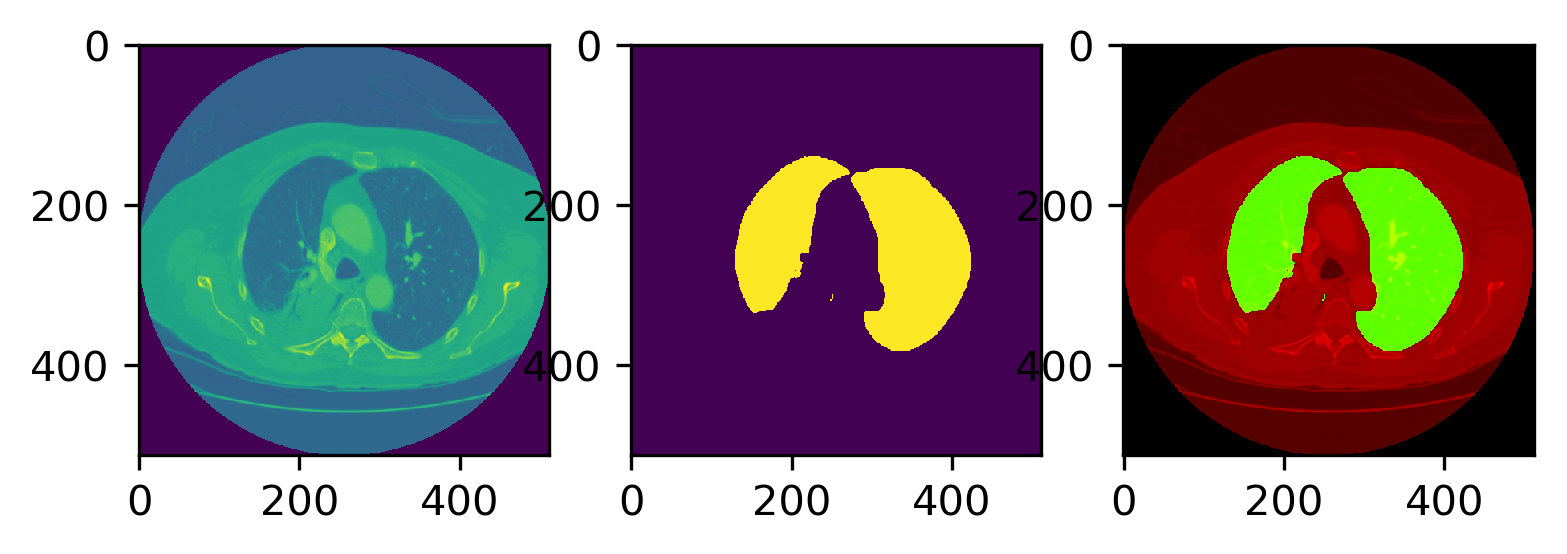

In [10]:
n = 100

plt.figure(dpi=300)
plt.subplot(1,3,1)
plt.imshow(ct0[n, :, :])

plt.subplot(1,3,2)
plt.imshow(msk1[n, :, :])

plt.subplot(1,3,3)
plt.imshow(overlap_pmaps(normalize(ct0[n, :, :]), msk1[n, :, :]))



In [90]:
print(set(msk0[:, :, :].flatten().tolist()))

{0, 3, 4, 5}


In [8]:
def get_1_lungmask(msk0):
    msk1 = np.copy(msk0)
    msk1[msk0==5] = 0
    msk1[msk0==4] = 1
    msk1[msk0==3] = 1
    return msk1

In [19]:
def get_multi_class_lungmask(msk0):
    msk2 = np.zeros((*msk0.shape, 2))
    msk2[msk0==4, 1] = 1
    msk2[msk0==3, 0] = 1
    
    return msk2

(512, 512, 2)


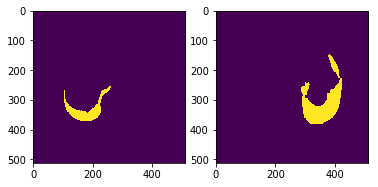

In [23]:
msk2 = get_multi_class_lungmask(msk0[60,:,:])
print(msk2.shape)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(msk2[:,:,1])

plt.subplot(1,2,2)
plt.imshow(msk2[:,:,0])

# creat example training data.

In [24]:
dct_sid_2_ct_msk = dict()

for ct in l_ct_mhd:
    sid = get_luna16_sid(ct)
    dct_sid_2_ct_msk[sid] = {"ct": ct}
    for msk in l_mask_mhd:
        if sid in msk:
            dct_sid_2_ct_msk[sid]["mask"] = msk
            break

In [32]:
train_h5 = h5py.File("/mnt/dfs/xjyan/patches/269_train_patch_2class.h5", "w")

In [33]:
test_h5 = h5py.File("/mnt/dfs/xjyan/patches/269_test_patch_2class.h5", "w")

In [34]:
ttsplit = int(len(dct_sid_2_ct_msk) * 0.8)
theRange = [0.25, 0.75]

for sid, d_ct_mask in tqdm(list(dct_sid_2_ct_msk.items())[:200]):
    
    p_ct = d_ct_mask["ct"]
    p_mask = d_ct_mask["mask"]
    
    ct = load_mhd(p_ct)[0]
    mask = get_multi_class_lungmask(load_mhd(p_mask)[0])
    
    slices = ct.shape[0]
    start = int(slices * theRange[0])
    end = int(slices * theRange[1])
    
    for i in range(start, end):
        g = train_h5.create_group(sid + str(i))
        g.create_dataset("ct_slice", data=ct[i,:,:])
        g.create_dataset("mask", data=mask[i,:,:].astype(np.int8))



  2%|▏         | 3/200 [00:05<06:09,  1.88s/it]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/xjyan/.conda/envs/py3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/xjyan/.conda/envs/py3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/xjyan/.conda/envs/py3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 32%|███▏      | 63/200 [03:02<06:37,  2.90s/it]

flip!
flip!


 78%|███████▊  | 156/200 [08:14<02:19,  3.17s/it]

flip!
flip!


 81%|████████  | 162/200 [08:34<02:00,  3.18s/it]

flip!
flip!


100%|██████████| 200/200 [10:41<00:00,  3.21s/it]


In [ ]:
ttsplit = int(len(dct_sid_2_ct_msk) * 0.8)
theRange = [0.25, 0.75]

for sid, d_ct_mask in tqdm(list(dct_sid_2_ct_msk.items())[200:250]):
    
    p_ct = d_ct_mask["ct"]
    p_mask = d_ct_mask["mask"]
    
    ct = load_mhd(p_ct)[0]
    mask = get_multi_class_lungmask(load_mhd(p_mask)[0])
    
    slices = ct.shape[0]
    start = int(slices * theRange[0])
    end = int(slices * theRange[1])
    
    for i in range(start, end):
        g = test_h5.create_group(sid + str(i))
        g.create_dataset("ct_slice", data=ct[i,:,:])
        g.create_dataset("mask", data=mask[i,:,:].astype(np.int8))


 60%|██████    | 30/50 [01:36<01:04,  3.21s/it]

In [116]:
print(len(test_h5))

23223


In [30]:
train_h5.close()

In [31]:
test_h5.close()

In [4]:
train_h5 = h5py.File("/mnt/dfs/xjyan/patches/269_test_patch_2class.h5", "r")

In [5]:
print(len(train_h5))

6524
